# Two-Layer Network Linear Regression
## Input the data

In [5]:
'''ML_noerror.csv, constant learning rate'''
import random
import torch
from torch import nn, optim
import math
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.preprocessing import StandardScaler
import time

t1 = time.monotonic()

D = 5  # dimensions
C = 1  # num_classes
H1 = 100  # num_hidden_units_1
H2 = 20  # num_hidden_units_2
H3 = 50  # num_hidden_units_3
H4 = 50  # num_hidden_units_4

filename = "ML_noerror.csv"     # print(data)
data_r = np.genfromtxt(filename, delimiter = ',', dtype = None, skip_header = 0, encoding = 'UTF-8')     #, usecols = [7,15,37,38,53]
[Row,Column] = data_r.shape     # 確認data(?)...print(data.shape); print(data); print(type(data[1,0]))
scaler = pp.MinMaxScaler().fit(data_r[:,1:6])     # 默認數據壓縮范圍為[0,1]
data_var = scaler.transform(data_r[:,1:6])
data_SOH = data_r[:,0:1]
data_all = np.hstack((data_SOH, data_var))     # 製作normalized features+未調整SOH數據
learning_rate = 1e-2
lambda_l2 = 5e-5
n_networks = 1     # Number of networks
criterion = torch.nn.MSELoss()     # nn package also has different loss functions. We use MSE for a regression task
totalerr_train = []; totalerr_test = []; total_corr = [];
train_set = []; test_set = []; eveloss = [];
models = list(); y_pretrain = list()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

features_train, features_test, soh_train, soh_test = train_test_split(data_all[:,1:6], data_all[:,0:1], test_size=0.2, random_state=100)
#print("features_train\n", features_train[0])
X_train = torch.from_numpy(features_train.astype(np.float64))
y_train = torch.from_numpy(soh_train.astype(np.float64))
X_test = torch.from_numpy(features_test.astype(np.float64))
y_test = torch.from_numpy(soh_test.astype(np.float64))

for mod in range(n_networks):
    model = nn.Sequential(
        nn.Linear(D, H1),
        nn.ReLU(), 
        nn.Linear(H1, H2),
        nn.ReLU(),
        nn.Linear(H2, C),
    )
    model.to(device)
  # Append models
    models.append(model)
  # Use the optim package to apply ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)     # built-in L2
    for t in range(50000):
      # Feed forward to get the logits     # print("test_set = ", test_set);     # 檢查是否正確取樣
        y_pred = model(X_train.float())
        if t == 0:
            y_pretrain.append(y_pred.detach())
          # Compute the loss and accuracy
        loss = torch.sqrt(criterion(y_pred.float(), y_train.float()))
        eveloss.append(np.round(loss.item(),6))
        print(f"[EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
        display.clear_output(wait=True)
      # zero the gradients before running
      # the backward pass.
        optimizer.zero_grad()
      # Backward pass to compute the gradient of loss w.r.t our learnable params. 
        loss.backward()
      # Update params
        optimizer.step()
        if t == 49999:
            totalerr_train.append(np.round(loss.item(),6))  
          ## Testing
            y_test_pred = model(X_test.float())
          # Compute the loss and accuracy
            loss_test = torch.sqrt(criterion(y_test_pred.float(), y_test.float()))
            y_test_array = []; y_test_pred_array = [];
            for ii in range(len(y_test)):
                y_test_array.append(y_test.detach().numpy()[ii][0].astype(np.float64))     # [ii]後面有時候要加[0]有時不用,使用時請注意資料集種類
                y_test_pred_array.append(y_test_pred.detach().numpy()[ii][0].astype(np.float64))
            R_sq = np.round(r2_score(y_test_pred_array, y_test_array),3)
            MAE = np.round(mean_absolute_error(y_test_pred_array, y_test_array),3)
            totalerr_test.append(np.round(loss_test.item(),6))
            total_corr.append(np.round(R_sq,3))

t2 = time.monotonic()
print("time elapsed:" + str(t2-t1) + " seconds")
# time elapsed:2556.8600000000442 seconds (梁主管)
# time elapsed:3091.5939999999828 seconds (我_lr=0.006)
# time elapsed:3169.469000000041 seconds (我_lr=0.01)

time elapsed:3169.469000000041 seconds


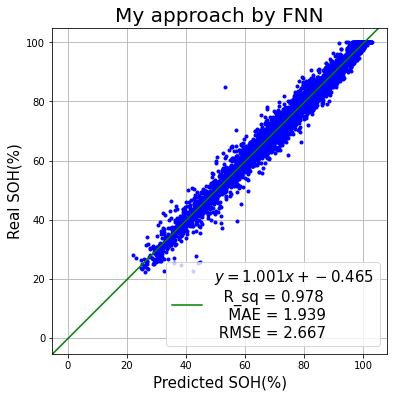

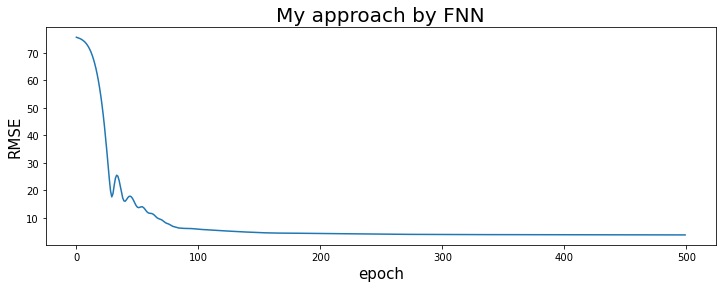

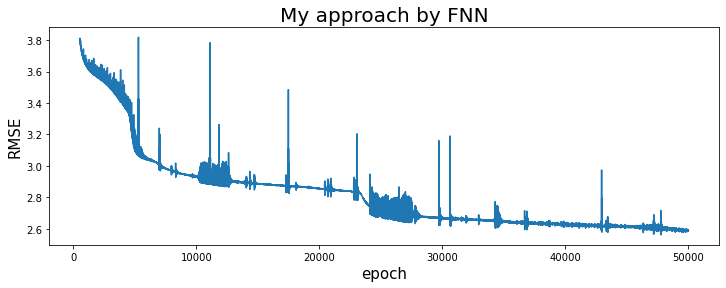

hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.01, lambda_l2 = 5e-05
Result_train =  [2.587714]
2.588
Result_test =  [2.66741]
2.667
total_corr(^2) =  [0.978]
0.978


In [6]:
plt.figure(figsize=(6,6))
plt.plot(y_test_pred_array, y_test_array, 'b.');     #
m1, b1 = np.polyfit(y_test_pred_array, y_test_array, 1);
plt.axline(xy1=(0, b1), slope=m1, color='g',
           label=f'$y = {m1:.3f}x +{b1:.3f}$\n  R_sq = {R_sq}\n   MAE = {MAE}\n RMSE = {loss_test:.3f}')
plt.xlabel("Predicted SOH(%)", fontsize=15)
plt.ylabel("Real SOH(%)", fontsize=15)
plt.title("My approach by FNN", fontsize=20);
plt.legend(fontsize=15)
plt.grid()
plt.savefig("My approach by FNN" + ".jpg"); plt.show();  #save as jpg
plt.figure(figsize=(12,4))
plt.plot(np.arange(0,500,1),eveloss[0:500]);     # ,'ro'
plt.xlabel("epoch", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.title("My approach by FNN", fontsize=20);
plt.savefig("My approach by FNN_loss curve_early" + ".jpg"); plt.show();     #save as jpg
plt.figure(figsize=(12,4))
plt.plot(np.arange(499,50000,1),eveloss[499:50000]);     # ,'ro'
plt.xlabel("epoch", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.title("My approach by FNN", fontsize=20);
plt.savefig("My approach by FNN_loss curve_later" + ".jpg"); plt.show();     #save as jpg'''

print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
# print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ' hidden_3= ' + f"{H3}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
# print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ' hidden_3= ' + f"{H3}" + ' hidden_4= ' + f"{H4}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
print("Result_train = ", totalerr_train); print(np.round(np.mean(totalerr_train),3))
print("Result_test = ", totalerr_test); print(np.round(np.mean(totalerr_test),3))
print("total_corr(^2) = ", total_corr); print(np.round(np.mean(total_corr),3))

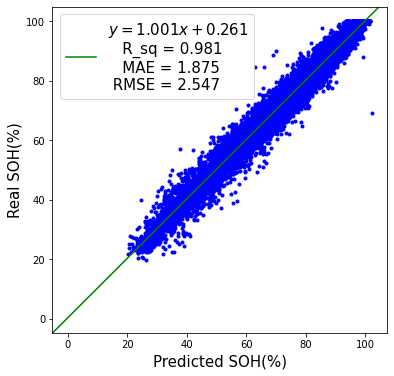

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

filename = "ML_noerror.csv"     # print(data)
data_r = np.genfromtxt(filename, delimiter = ',', dtype = None, skip_header = 0, encoding = 'UTF-8')     #, usecols = [7,15,37,38,53]
[Row,Column] = data_r.shape     # 確認data(?)...print(data.shape); print(data); print(type(data[1,0]))
scaler = pp.MinMaxScaler().fit(data_r[:,1:6])     # 默認數據壓縮范圍為[0,1]
data_SOH = data_r[:,0:1]
data_var = scaler.transform(data_r[:,1:6])     ## 合併數據: data = np.hstack((data_SOH, data_var))     # 製作normalized features+未調整SOH數據
data_SOH_st = torch.from_numpy(data_SOH.astype(np.float64))
data_var_st = torch.from_numpy(data_var.astype(np.float64))

data_SOH_st_pred = model(data_var_st.float())

# # # detach
data_SOH_st_pred_detach = data_SOH_st_pred.detach().numpy()     # [ii][0].astype(np.float64)
data_SOH_st_detach = data_SOH_st.detach().numpy()     # [ii][0].astype(np.float64)
#print(data_SOH_st_pred_detach); print(data_SOH_st_detach)
poster_pred = [];
poster_real = [];
for ii in range(len(data_SOH_st_detach)):
    poster_real.append(data_SOH_st_detach[ii][0].astype(np.float64))
    poster_pred.append(data_SOH_st_pred_detach[ii][0].astype(np.float64))

# Evaluate the cost
criterion = torch.nn.MSELoss()
loss_all = np.round(torch.sqrt(criterion(data_SOH_st_pred.float(), data_SOH_st.float())).item(),3)     # .float()
R = np.corrcoef(poster_pred, poster_real)[0,1];
R_sq = np.round(R*R,3)
MAE = np.round(mean_absolute_error(poster_pred, poster_real),3)

# Plot the result
plt.figure(figsize=(6,6))
plt.plot(poster_pred, poster_real, 'b.');     #
m1, b1 = np.polyfit(poster_pred, poster_real, 1);
plt.axline(xy1=(0, b1), slope=m1, color='g', label=f'$y = {m1:.3f}x {b1:+.3f}$\n   R_sq = {R_sq}\n   MAE = {MAE}\n RMSE = {loss_all.item():.3f}') # 
plt.xlabel("Predicted SOH(%)", fontsize=15)
plt.ylabel("Real SOH(%)", fontsize=15)
# plt.title("" + "_" + f"{i}", fontsize=20);
plt.legend(fontsize=15)
plt.savefig("Poster Competition" + ".jpg"); plt.show();  #save as jpg


In [ ]:
'''原始、有交叉驗證的code'''
for i in range(5):
    train_set = [];
    test_set = [];
    eveloss = [];
    models = list()
    y_pretrain = list()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for j in range(len(data)):
        if j%5 == i:
            test_set.append(j)
        else:
            train_set.append(j)
    X = torch.from_numpy(data[train_set,1:6].astype(np.float64))
    y = torch.from_numpy(data[train_set,0:1].astype(np.float64))
    X_test = torch.from_numpy(data[test_set,1:6].astype(np.float64))
    y_test = torch.from_numpy(data[test_set,0:1].astype(np.float64))
    for mod in range(n_networks):
      # nn package to create our linear model     # https://stackoverflow.com/questions/46141690/how-do-i-write-a-pytorch-sequential-model
      # each Linear module has a weight and bias     # https://discuss.pytorch.org/t/mlp-with-one-hidden-layer-dimensions-modules/48841
        model = nn.Sequential(
            nn.Linear(D, H1),
            nn.ReLU(),     # if mod < n_networks // 2 else nn.Tanh(),
            nn.Linear(H1, H2),
            nn.ReLU(),     # if mod < n_networks // 2 else nn.Tanh(),
            nn.Linear(H2, C),
            #nn.ReLU(),     # if mod < n_networks // 2 else nn.Tanh(),
            #nn.Linear(H3, H4),
            #nn.ReLU(),     # if mod < n_networks // 2 else nn.Tanh(),
            #nn.Linear(H4, C)
        )
        model.to(device)
      # Append models
        models.append(model)
      # we use the optim package to apply
      # ADAM for our parameter updates
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)     # built-in L2
      # e = 1.  # plotting purpose.
      ## Training
        for t in range(50000):
          # Feed forward to get the logits     # print("test_set = ", test_set);     # 檢查是否正確取樣
            y_pred = model(X.float())
          # Append pre-train output
            if t == 0:
                y_pretrain.append(y_pred.detach())
          # Compute the loss and accuracy
            loss = torch.sqrt(criterion(y_pred.float(), y.float()))
            eveloss.append(np.round(loss.item(),6))
            print(f"[Round]: {i+1}, [MODEL]: {mod + 1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
            display.clear_output(wait=True)
          # zero the gradients before running
          # the backward pass.
            optimizer.zero_grad()
          # Backward pass to compute the gradient of loss w.r.t our learnable params. 
            loss.backward()
          # Update params
            optimizer.step()
            if t == 49999:
                totalerr_train.append(np.round(loss.item(),6))  
              ## Testing
                y_test_pred = model(X_test.float())
              # Compute the loss and accuracy
                loss_test = torch.sqrt(criterion(y_test_pred.float(), y_test.float()))
                y_test_array = []; y_test_pred_array = [];
                for ii in range(len(y_test)):
                    y_test_array.append(y_test.detach().numpy()[ii][0].astype(np.float64))
                    y_test_pred_array.append(y_test_pred.detach().numpy()[ii][0].astype(np.float64))
                R = np.corrcoef(y_test_array, y_test_pred_array)[0,1];     ##[0,1],造成dead kernel
                R_sq = np.round(R*R,3)
                totalerr_test.append(np.round(loss_test.item(),6))
                total_corr.append(np.round(R_sq,3))
                ## 畫圖'''
                plt.figure(figsize=(6,6))
                plt.plot(y_test_pred_array, y_test_array, 'b.');     #
                m1, b1 = np.polyfit(y_test_pred_array, y_test_array, 1);
                plt.axline(xy1=(0, b1), slope=m1, color='g', label=f'$y = {m1:.3f}x {b1:+.3f}$\n R^2 = {R_sq}\n loss_train = {loss.item():.3f}\n loss_test = {loss_test:.3f}') # 
                plt.xlabel("Predicted SOH(%)", fontsize=15)
                plt.ylabel("Real SOH(%)", fontsize=15)
                plt.title("Testing result(η=constant)" + "_" + f"{i}", fontsize=20);
                plt.legend(fontsize=15)
                plt.savefig("Testing result(η=constant)" + "_Round " + f"{i}" + ".jpg"); plt.show();  #save as jpg
                plt.figure(figsize=(12,4))
                plt.plot(np.arange(0,500,1),eveloss[0:500]);     # ,'ro'
                plt.xlabel("epoch", fontsize=15)
                plt.ylabel("RMSE", fontsize=15)
                plt.title("Estimation error curve(η=const, init)" + "_" + f"{i}", fontsize=20);
                plt.savefig("Estimation error curve(η=const, init)" + "_" + f"{i}" + ".jpg"); plt.show();     #save as jpg
                plt.figure(figsize=(12,4))
                plt.plot(np.arange(499,50000,1),eveloss[499:50000]);     # ,'ro'
                plt.xlabel("epoch", fontsize=15)
                plt.ylabel("RMSE", fontsize=15)
                plt.title("Estimation error curve(η=constant, end)" + "_" + f"{i}", fontsize=20);
                plt.savefig("Estimation error curve(η=constant, end)" + "_" + f"{i}" + ".jpg"); plt.show();     #save as jpg'''

# print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
# print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ' hidden_3= ' + f"{H3}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
# print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ' hidden_3= ' + f"{H3}" + ' hidden_4= ' + f"{H4}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
print("Result_train = ", totalerr_train); print(np.round(np.mean(totalerr_train),3))
print("Result_test = ", totalerr_test); print(np.round(np.mean(totalerr_test),3))
print("total_corr(^2) = ", total_corr); print(np.round(np.mean(total_corr),3))

In [ ]:
'''ML_noerror.csv, varying learning rate:更動optimizer出現位置'''
import random
import torch
from torch import nn, optim
import math
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp

D = 5  # dimensions
C = 1  # num_classes
H1 = 50  # num_hidden_units_1
H1 = 5  # num_hidden_units_2

filename = "ML_noerror.csv"     # print(data)
data_r = np.genfromtxt(filename, delimiter = ',', dtype = None, skip_header = 0, encoding = 'UTF-8')     #, usecols = [7,15,37,38,53]
[Row,Column] = data_r.shape     # 確認data(?)...print(data.shape); print(data); print(type(data[1,0]))
scaler = pp.MinMaxScaler().fit(data_r[:,1:6])     # 默認數據壓縮范圍為[0,1]
data_var = scaler.transform(data_r[:,1:6])
data_SOH = data_r[:,0:1]
data = np.hstack((data_SOH, data_var))     # 製作normalized features+未調整SOH數據
learning_rate = 1e-1
lambda_l2 = 5e-4
n_networks = 1     # Number of networks
criterion = torch.nn.MSELoss()     # nn package also has different loss functions. We use MSE for a regression task
totalerr_train = []; totalerr_test = []; total_corr = [];

for i in range(3):
    train_set = [];
    test_set = [];
    eveloss = [];
    models = list()
    y_pretrain = list()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for j in range(len(data)):
        if j%10 == i:
            test_set.append(j)
        else:
            train_set.append(j)
    X = torch.from_numpy(data[train_set,1:6].astype(np.float64))
    y = torch.from_numpy(data[train_set,0:1].astype(np.float64))
    X_test = torch.from_numpy(data[test_set,1:6].astype(np.float64))
    y_test = torch.from_numpy(data[test_set,0:1].astype(np.float64))
    for mod in range(n_networks):
      # nn package to create our linear model     # https://stackoverflow.com/questions/46141690/how-do-i-write-a-pytorch-sequential-model
      # each Linear module has a weight and bias     # https://discuss.pytorch.org/t/mlp-with-one-hidden-layer-dimensions-modules/48841
        model = nn.Sequential(
            nn.Linear(D, H1),
            nn.ReLU(),     # if mod < n_networks // 2 else nn.Tanh(),
            nn.Linear(H1, H2),
            nn.ReLU(),     # if mod < n_networks // 2 else nn.Tanh(),
            nn.Linear(H2, C)
        )
        model.to(device)
      # Append models
        models.append(model)
      # e = 1.  # plotting purpose.
      ## Training
        for t in range(20000):
          # Feed forward to get the logits
            y_pred = model(X.float())
          # Append pre-train output
            if t == 0:
                y_pretrain.append(y_pred.detach())
          # Compute the loss and accuracy
            loss = torch.sqrt(criterion(y_pred.float(), y.float()))
            eveloss.append(np.round(loss.item(),6))
            print(f"[Round]: {i+1}, [MODEL]: {mod + 1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
            display.clear_output(wait=True)
          # Varying learning rate
            
          # we use the optim package to apply ADAM
          # for our parameter updates
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)     # built-in L2
          # zero the gradients before running
          # the backward pass.
            optimizer.zero_grad()
          # Backward pass to compute the gradient of loss w.r.t our learnable params. 
            loss.backward()
          # Update params
            optimizer.step()
            if t == 19999:
                totalerr_train.append(np.round(loss.item(),6))  
              ## Testing
                y_test_pred = model(X_test.float())
              # Compute the loss and accuracy
                loss_test = torch.sqrt(criterion(y_test_pred.float(), y_test.float()))
                y_test_array = []; y_test_pred_array = [];
                for ii in range(len(y_test)):
                    y_test_array.append(y_test.detach().numpy()[ii][0].astype(np.float64))
                    y_test_pred_array.append(y_test_pred.detach().numpy()[ii][0].astype(np.float64))
                R = np.corrcoef(y_test_array, y_test_pred_array)[0,1];     ##[0,1],造成dead kernel
                R_sq = np.round(R*R,3)
                totalerr_test.append(np.round(loss_test.item(),6))
                total_corr.append(np.round(R_sq,3))
                ## 畫圖'''
                plt.figure(figsize=(6,6))
                plt.plot(y_test_pred_array, y_test_array, 'ro');     #
                m1, b1 = np.polyfit(y_test_pred_array, y_test_array, 1);
                plt.axline(xy1=(0, b1), slope=m1, color='g', label=f'$y = {m1:.3f}x {b1:+.3f}$\n R^2 = {R_sq}\n loss_train = {loss.item():.3f}\n loss_test = {loss_test:.3f}') # 
                plt.xlabel("Predicted SOH(%)", fontsize=15)
                plt.ylabel("Real SOH(%)", fontsize=15)
                plt.title("Training result" + "_" + f"{i}", fontsize=20);
                plt.legend(fontsize=15); plt.savefig("Training result" + "_Round " + f"{i}" + ".jpg"); plt.show();  #save as jpg
                plt.figure(figsize=(12,4))
                plt.plot(np.arange(0,401,1),eveloss[0:401]);     # ,'ro'
                plt.xlabel("epoch", fontsize=15)
                plt.ylabel("RMSE", fontsize=15)
                plt.title("Estimation error curve(0~400)" + "_" + f"{i}", fontsize=20);
                plt.savefig("Estimation error curve(0~400)" + "_" + f"{i}" + ".jpg"); plt.show();  #save as jpg
                plt.figure(figsize=(12,4))
                plt.plot(np.arange(401,100000,1),eveloss[401:]);     # ,'ro'
                plt.xlabel("epoch", fontsize=15)
                plt.ylabel("RMSE", fontsize=15)
                plt.title("Estimation error curve(400~end)" + "_" + f"{i}", fontsize=20);
                plt.savefig("Estimation error curve(400~end)" + "_" + f"{i}" + ".jpg"); plt.show(); #save as jpg'''

print("hyperparameters = ", 'Epoch = 100000' + ',' + ' hidden unit = ' + f"{H}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
print("Result_train = ", totalerr_train); print(np.round(np.mean(totalerr_train),3))
print("Result_test = ", totalerr_test); print(np.round(np.mean(totalerr_test),3))
print("total_corr(^2) = ", total_corr); print(np.round(np.mean(total_corr),3))


In [70]:
import numpy as np
from sklearn import preprocessing as pp

filename = "ML_noerror.csv"     # print(data)
data_r = np.genfromtxt(filename, delimiter = ',', dtype = None, skip_header = 0, encoding = 'UTF-8')     #, usecols = [7,15,37,38,53]
[Row,Column] = data_r.shape     # 確認data(?)...print(data.shape); print(data); print(type(data[1,0]))

scaler = pp.MinMaxScaler().fit(data_r[0:18,1:6]) # 默認數據壓縮范圍為[0,1]
data_var = scaler.transform(data_r[0:18,1:6])
print("data_var\n", data_var); print(len(data_var))
data_SOH = data_r[0:18,0:1]
data = np.hstack((data_SOH, data_var))
print("data\n", data); print(len(data))

for i in range(5):
    train_set = [];
    test_set = [];
    for j in range(len(data)):
        if j%5 == i:
            test_set.append(j)
        else:
            train_set.append(j)
    # print(train_set); print(test_set)
    X = torch.from_numpy(data[train_set,1:6].astype(np.float64))
    y = torch.from_numpy(data[train_set,0:1].astype(np.float64))
    X_test = torch.from_numpy(data[test_set,1:6].astype(np.float64))
    y_test = torch.from_numpy(data[test_set,0:1].astype(np.float64))
print("X\n", X); print("X_test\n", X_test);
print("y\n", y); print("y_test\n", y_test);


data_var
 [[0.53389831 0.86437613 0.0362886  0.69837587 0.625     ]
 [0.69491525 0.91862568 0.01636545 0.86078886 0.375     ]
 [0.53389831 0.52622061 0.03130781 0.75251353 0.5625    ]
 [0.50847458 0.49005425 0.04724634 0.65197216 0.65625   ]
 [0.54237288 0.52622061 0.03756938 0.73704563 0.5625    ]
 [0.52542373 0.50813743 0.03941938 0.68290797 0.59375   ]
 [0.51694915 0.53616637 0.02846165 0.75251353 0.53125   ]
 [0.5        0.53345389 0.03016935 0.73704563 0.5625    ]
 [0.5        0.54611212 0.03045396 0.76024749 0.5625    ]
 [0.5        0.52350814 0.04340401 0.69837587 0.625     ]
 [0.44915254 0.53345389 0.04070016 0.69837587 0.59375   ]
 [0.40677966 0.51898734 0.05436175 0.64423821 0.625     ]
 [0.37288136 0.46654611 0.08339263 0.54369683 0.71875   ]
 [0.39830508 0.51446655 0.06688487 0.6133024  0.65625   ]
 [0.45762712 0.45840868 0.08481571 0.53596288 0.6875    ]
 [0.34745763 0.46202532 0.10032731 0.52049497 0.71875   ]
 [1.         1.         0.         1.         0.        ]
 [0.

In [24]:
'''dead kernel時,持續run這裡就能解除'''
#print("y_test_array\n", y_test_array); print(len(y_test_array)); print(type(y_test_array))
#print("y_test_pred_array\n", y_test_pred_array); print(len(y_test_pred_array)); print(type(y_test_pred_array))

A = [88.44329833984375, 76.34779357910156, 75.89508819580078, 99.53396606445312, 80.5982666015625]; print(type(A))
B = [100.0, 93.4, 91.6, 100.0, 94.1]; print(type(B))

import numpy as np
R = np.corrcoef(y_test_array, y_test_pred_array)[0,1]     # totalerr_train;totalerr_test
print("R\n", R)

<class 'list'>
<class 'list'>
R
 0.9231149889657987


In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.plot(y_test_pred_array, y_test_array,'ro');     # ,'ro'
plt.xlabel("Predict SOH", fontsize=15)
plt.ylabel("Real SOH", fontsize=15)
# plt.title("Estimation error curve(0~100)" + "_" + f"{i}", fontsize=20);
# plt.savefig("Estimation error curve(0~100)" + "_" + f"{i}" + ".jpg"); plt.show();  #save as jpg


NameError: name 'y_test_pred_array' is not defined

<Figure size 288x288 with 0 Axes>

In [6]:
remainder = [0,1,2,3,4,5,6,7,8,9]
file = np.asarray([remainder,totalerr_train,totalerr_test])     # inf2,inf2T
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\數據_機器學習\訓練50k次結果.csv',file,delimiter=',')
print("file = \n", file)

file = 
 [[0.       1.       2.       3.       4.       5.       6.       7.
  8.       9.      ]
 [4.728859 4.453703 4.900453 5.046527 4.478639 4.784751 4.450714 4.45284
  4.675649 5.012812]
 [4.95113  4.500827 4.855975 5.166975 4.556354 4.949872 4.666337 4.46393
  4.707827 5.029951]]


In [3]:
'''Variable_Modified.csv'''
import random
import torch
from torch import nn, optim
import math
from IPython import display
import numpy as np
import matplotlib.pyplot as plt

# N = 1000  # num_samples_per_class
D = 4  # dimensions
C = 1  # num_classes
H = 98  # num_hidden_units

filename = "Variables_Modified.csv"     # print(data)
data = np.genfromtxt(filename, delimiter = ',', dtype = None, skip_header = 0, usecols = [7,15,37,38,53], encoding = 'UTF-8')[1:,:]     #, usecols = [7,15,37,38,53]
[Row,Column] = data.shape     # 確認data(?)...print(data.shape); print(data); print(type(data[1,0]))
learning_rate = 6e-2
lambda_l2 = 9e-5
n_networks = 1     # Number of networks
criterion = torch.nn.MSELoss()     # nn package also has different loss functions. We use MSE for a regression task
totalerr_train = [];
totalerr_test = [];
total_corr = [];

for i in range(5):
    train_set = [];
    test_set = [];
    eveloss = [];
    models = list()
    y_pretrain = list()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for j in range(len(data)):
        if j%5 == i:
            test_set.append(j)
        else:
            train_set.append(j)
    X = torch.from_numpy(data[train_set,0:4].astype(np.float64))
    y = torch.from_numpy(data[train_set,4:5].astype(np.float64))
    X_test = torch.from_numpy(data[test_set,0:4].astype(np.float64))
    y_test = torch.from_numpy(data[test_set,4:5].astype(np.float64))
    for mod in range(n_networks):
      # nn package to create our linear model     # https://stackoverflow.com/questions/46141690/how-do-i-write-a-pytorch-sequential-model
      # each Linear module has a weight and bias     # https://discuss.pytorch.org/t/mlp-with-one-hidden-layer-dimensions-modules/48841
        model = nn.Sequential(
            nn.Linear(D, H),
            nn.ReLU(),     # if mod < n_networks // 2 else nn.Tanh(),
            nn.Linear(H, C)
        )
        model.to(device)
      # Append models
        models.append(model)
      # we use the optim package to apply
      # ADAM for our parameter updates
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)     # built-in L2
      # e = 1.  # plotting purpose.
      ## Training
        for t in range(2000):
          # Feed forward to get the logits
            print("test_set = ", test_set);     # 檢查是否正確取樣
            y_pred = model(X.float())
          # Append pre-train output
            if t == 0:
                y_pretrain.append(y_pred.detach())
          # Compute the loss and accuracy
            loss = torch.sqrt(criterion(y_pred.float(), y.float()))
            eveloss.append(np.round(loss.item(),6))
            print(f"[Round]: {i+1}, [MODEL]: {mod + 1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
            display.clear_output(wait=True)
          # zero the gradients before running
          # the backward pass.
            optimizer.zero_grad()
          # Backward pass to compute the gradient
          # of loss w.r.t our learnable params. 
            loss.backward()
          # Update params
            optimizer.step()
            if t == 1999:
                totalerr_train.append(np.round(loss.item(),6))  
              ## Testing
                y_test_pred = model(X_test.float())
              # Compute the loss and accuracy
                loss_test = torch.sqrt(criterion(y_test_pred.float(), y_test.float()))
                y_test_array = []; y_test_pred_array = [];
                for i in range(len(y_test)):
                    y_test_array.append(y_test.detach().numpy()[i][0].astype(np.float64))
                    y_test_pred_array.append(y_test_pred.detach().numpy()[i][0].astype(np.float64))
                #R = np.corrcoef(y_test_array, y_test_pred_array)[0,1];     ##[0,1]
                #R_sq = np.round(R*R,3)
                totalerr_test.append(np.round(loss_test.item(),6))
                #total_corr.append(np.round(R_sq,3))
                #print(eveloss); print(len(eveloss))
                ## 畫圖
                '''plt.figure(figsize=(12,4))
                plt.plot(np.arange(0,97,1),eveloss[0:97]);     # ,'ro'
                plt.show()
                plt.xlabel("epoch", fontsize=15)
                plt.ylabel("RMSE", fontsize=15)
                plt.title("Estimation error curve(Cary)" + "_" + f"{i}", fontsize=20);
                plt.savefig("Estimation error curve(Cary)" + "_" + f"{i}" + ".jpg"); plt.show();  #save as jpg'''

print("Result_train = ", totalerr_train); print(np.mean(totalerr_train))
print("Result_test = ", totalerr_test); print(np.mean(totalerr_test))
# print("total_corr(^2) = ", total_corr); print(np.mean(total_corr))


Result_train =  [159.233963, 156.062897, 155.430481, 153.099091, 153.597946]
155.48487559999998
Result_test =  [110.906822, 156.678131, 166.546677, 260.596008, 145.016174]
167.94876240000002


In [ ]:
print("Result_train = ", totalerr_train); print(np.mean(totalerr_train))
print("Result_test = ", totalerr_test); print(np.mean(totalerr_test))
print("total_corr = ", total_corr); print(np.mean(total_corr))


In [ ]:
# print("X_test = ", X_test)
## Testing
y_test_pred = model(X_test.float())
# Compute the loss and accuracy
loss_test = torch.sqrt(criterion(y_test_pred.float(), y_test.float()))
print("Result_test = ", f"[LOSS]: {loss_test.item():.6f}")
# yy = [[1864, 1976, 741, 1709, 1974, 1995, 1023, 1408, 1327, 1761, 1454, 1217, 1379, 2002, 2139, 2113, 2017, 2222]]
# yyp = [[1791.2426, 1942.0934, 636.8153, 1621.7992, 1965.6481, 1941.7233, 863.53064, 1509.7202, 1195.118, 1823.732, 1352.1896, 1177.4498, 1418.5863, 1941.7146, 2053.373, 2079.6008, 2004.9053, 2238.9387]]
y_test_array = []; y_test_pred_array = [];
for i in range(len(y_test)):
    y_test_array.append(y_test.detach().numpy()[i][0].astype(np.float64))
    y_test_pred_array.append(y_test_pred.detach().numpy()[i][0].astype(np.float64))
R = np.corrcoef(y_test_array, y_test_pred_array)[0,1];     ##[0,1]
R_sq = np.round(R*R,3)
print("R_sq = ", R_sq)     #_sq_sq''''''
# print("y_test = \n", y_test_array)
# print("y_test_pred = \n", y_test_pred_array)
print("pred_RMSE = ", y_test_pred-y_test)

## Linear model

In [ ]:
learning_rate = 9e-3
lambda_l2 = 9e-5

In [ ]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) # Convert to CUDA

# nn package also has different loss functions.
# we use MSE loss for our regression task
criterion = torch.nn.MSELoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(5000):
    
    # Feed forward to get the logits
    y_pred = model(X.float())
    
    # Compute the loss (MSE)
    loss = torch.sqrt(criterion(y_pred.float(), y.float()))
    print("[EPOCH]: %i, [LOSS or RMSE]: %.6f" % (t, loss.item()))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

In [ ]:
# Plot trained model
print(model)

In [ ]:
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5)
#plt.axis('equal');

In [ ]:
'''紀錄成果的地方'''
(2022.1202.0919~1355)
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.01, lambda_l2 = 5e-05
Result_train =  [2.519021, 2.534965, 2.564647, 2.566402, 2.531003]
2.543
Result_test =  [2.603306, 2.750981, 2.53465, 2.669222, 2.569345]
2.626
total_corr(^2) =  [0.98, 0.977, 0.981, 0.979, 0.98]
0.979

(2022.1109.1055~1114收,把Testing result改成藍點繪圖)
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.01, lambda_l2 = 5e-05
Result_train =  [2.480602, 2.538828, 2.553459, 2.540704, 2.62451, 2.528014, 2.548229, 2.537054, 2.581324, 2.623085]
2.556
Result_test =  [2.615936, 2.729832, 2.567802, 2.562017, 2.658864, 2.607752, 2.69983, 2.532249, 2.733023, 2.554496]
2.626
total_corr(^2) =  [0.98, 0.978, 0.981, 0.981, 0.978, 0.98, 0.979, 0.98, 0.978, 0.981]
0.98

(2022.1109.1152~)
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.01, lambda_l2 = 5e-05
Result_train =  [2.494299, 2.507101, 2.583198, 2.506455, 2.557944, 2.512834, 2.619464, 2.602276, 2.512936, 2.574215]
2.547
Result_test =  [2.626379, 2.763141, 2.538544, 2.628495, 2.715135, 2.613287, 2.828317, 2.572354, 2.628479, 2.532271]
2.645
total_corr(^2) =  [0.98, 0.978, 0.981, 0.98, 0.978, 0.98, 0.977, 0.98, 0.979, 0.981]
0.979

(2022.1108.18xx~約8hr)
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.01, lambda_l2 = 5e-05
Result_train =  [2.58034, 2.546033, 2.468841, 2.489193, 2.554123, 2.474051, 2.626178, 2.555791, 2.496691, 2.544762]
2.534
Result_test =  [2.689496, 2.677756, 2.51819, 2.57944, 2.687416, 2.560177, 2.807391, 2.536913, 2.624151, 2.493174]
2.617
total_corr(^2) =  [0.979, 0.979, 0.982, 0.98, 0.979, 0.981, 0.977, 0.98, 0.979, 0.981]
0.98

(2022.1105.0838~約8hr)
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.006, lambda_l2 = 5e-05 (常震動,幅度小而未收斂)
Result_train =  [2.632437, 2.650549, 2.674485, 2.640071, 2.591238, 2.703607, 2.68501, 2.65073, 2.639117, 2.636186]
2.65
Result_test =  [2.765985, 2.884074, 2.694629, 2.806585, 2.632702, 2.657015, 2.868555, 2.565015, 2.814294, 2.641591]
2.733
total_corr(^2) =  [0.978, 0.976, 0.979, 0.977, 0.979, 0.98, 0.975, 0.979, 0.976, 0.98]
0.978

(2022.1104.1759~)
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.02, lambda_l2 = 5e-05 (劇抖,而且變差)
Result_train =  [2.595533, 2.487264, 2.515431, 2.499616, 2.479866, 2.488069, 2.472229, 2.504586, 2.502895, 2.76678]
2.531
Result_test =  [2.739825, 2.687254, 2.549858, 2.575533, 2.632511, 2.592375, 2.742994, 2.491621, 2.656164, 2.854884]
2.652
total_corr(^2) =  [0.978, 0.978, 0.982, 0.981, 0.979, 0.98, 0.977, 0.981, 0.978, 0.98]
0.979

(2022.1104.1000~1746)
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.01, lambda_l2 = 5e-05 (總是震動卻未收斂)
Result_train =  [2.484854, 2.556363, 2.515881, 2.57764, 2.569483, 2.540704, 2.49545, 2.580492, 2.566472, 2.548776]
2.544
Result_test =  [2.684848, 2.678122, 2.507932, 2.69313, 2.689964, 2.618042, 2.67353, 2.516735, 2.701908, 2.472736]
2.624
total_corr(^2) =  [0.979, 0.979, 0.982, 0.98, 0.978, 0.981, 0.978, 0.981, 0.978, 0.982]
0.98

(以前資料)
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;; learning_rate = 0.006, lambda_l2 = 5e-05 (error curve會抖)
Result_train =  [2.60525, 2.52635, 2.609072, 2.703397, 2.595881, 2.677424, 2.635951, 2.689419, 2.608169, 2.661216]
2.631
Result_test =  [2.794916, 2.706621, 2.57667, 2.856071, 2.725277, 2.710176, 2.855808, 2.628233, 2.727458, 2.539536]
2.712
total_corr(^2) =  [0.977, 0.978, 0.981, 0.977, 0.977, 0.979, 0.976, 0.979, 0.977, 0.981]
0.978

-----------------------------------------------------做poster------------------------------------------------------------
(2022.1102.1812~)
hyperparameters =  Epoch = 50000, hidden_1= 30;; hidden_2= 30;; hidden_3= 30 hidden_4= 30,learning_rate = 0.03, lambda_l2 = 5e-05 (劇抖,而且變差)
Result_train =  [2.527336, 2.491901, 2.465807, 2.535769, 2.44197, 2.50803, 2.656109, 2.501853, 2.513056, 2.608956]
2.525
Result_test =  [2.715464, 2.687381, 2.519658, 2.59183, 2.786281, 2.594271, 2.852002, 2.548773, 2.732043, 2.618358]
2.665
total_corr(^2) =  [0.978, 0.978, 0.982, 0.981, 0.977, 0.98, 0.976, 0.98, 0.977, 0.982]
0.979

(2022.1101.1815~)
hyperparameters =  Epoch = 50000, hidden_1= 30;; hidden_2= 30;; hidden_3= 30 hidden_4= 30,learning_rate = 0.02, lambda_l2 = 5e-05 (抖得更劇烈)
Result_train =  [2.436175, 2.569425, 2.45131, 2.383965, 2.45072, 2.473114, 2.536918, 2.395475, 2.476123, 2.583385]
2.476
Result_test =  [2.683545, 2.747995, 2.488507, 2.566587, 2.802786, 2.589757, 2.702038, 2.48665, 2.707846, 2.552442]
2.633
total_corr(^2) =  [0.979, 0.978, 0.982, 0.981, 0.977, 0.981, 0.978, 0.981, 0.978, 0.981]
0.98

(2022.1028.0920~)
hyperparameters =  Epoch = 50000, hidden_1= 30;; hidden_2= 30;; hidden_3= 30 hidden_4= 30,learning_rate = 0.01, lambda_l2 = 5e-05 (劇烈抖動)
Result_train =  [2.547982, 2.503142, 2.593261, 2.473942, 2.505827, 2.516804, 2.539217, 2.507152, 2.484884, 2.520236]
2.519
Result_test =  [2.734553, 2.712412, 2.596972, 2.584443, 2.635072, 2.58593, 2.863439, 2.515682, 2.709177, 2.521935]
2.646
total_corr(^2) =  [0.979, 0.978, 0.981, 0.98, 0.979, 0.981, 0.976, 0.98, 0.978, 0.981]
0.979

(2022.1026.1828~missed)
hyperparameters =  Epoch = 50000, hidden_1= 30;; hidden_2= 30;; hidden_3= 30 hidden_4= 30,learning_rate = 0.006, lambda_l2 = 5e-05
Result_train =  [2.517156, 2.540708, 2.757319, 2.542225, 2.576773, 2.543879, 2.558589, 2.627371, 2.543447, 2.638859]
2.585
Result_test =  [2.756954, 2.756898, 2.811918, 2.61277, 2.617508, 2.647014, 2.771841, 2.537872, 2.66082, 2.575994]
2.675
total_corr(^2) =  [0.978, 0.977, 0.979, 0.98, 0.979, 0.98, 0.977, 0.98, 0.979, 0.98]
0.979

(2022.1026.1158~1722)
hyperparameters =  Epoch = 50000, hidden_1= 20;; hidden_2= 20;; hidden_3= 20 hidden_4= 20,learning_rate = 0.006, lambda_l2 = 5e-05
Result_train =  [2.623523, 2.568017, 2.63782, 2.628969, 2.591393, 2.648983, 2.560097, 2.611713, 2.594523, 2.632643]
2.61
Result_test =  [2.757114, 2.749587, 2.616082, 2.636534, 2.6839, 2.668018, 2.806965, 2.612988, 2.750397, 2.620575]
2.69
total_corr(^2) =  [0.978, 0.978, 0.98, 0.98, 0.978, 0.98, 0.976, 0.979, 0.977, 0.98]
0.979

(2022.1026.1006~1150)
hyperparameters =  Epoch = 50000, hidden_1= 10;; hidden_2= 10;; hidden_3= 10 hidden_4= 10,learning_rate = 0.006, lambda_l2 = 5e-05
Result_train =  [2.902112, 3.548272, 2.899542, 2.959663, 3.001722, 3.066143, 2.952542, 2.726195, 2.950228, 3.031115]
3.004
Result_test =  [2.975725, 3.636121, 2.902618, 3.038369, 2.982562, 3.0231, 3.124437, 2.656121, 3.070239, 2.933566]
3.034
total_corr(^2) =  [0.974, 0.96, 0.976, 0.973, 0.973, 0.973, 0.971, 0.978, 0.971, 0.974]
0.972

hyperparameters =  Epoch = 50000, hidden_1= 60;; hidden_2= 60;; hidden_3= 60,learning_rate = 0.006, lambda_l2 = 5e-05 (21小時)
Result_train =  [2.416123, 2.393784, 2.533159, 2.454593, 2.456993, 2.45416, 2.441202, 2.434832, 2.51023, 2.456154]
2.455
Result_test =  [2.647737, 2.618425, 2.600487, 2.582572, 2.653266, 2.542382, 2.701309, 2.44695, 2.708033, 2.498056]
2.6
total_corr(^2) =  [0.979, 0.979, 0.982, 0.981, 0.979, 0.981, 0.978, 0.981, 0.978, 0.981]
0.98

hyperparameters =  Epoch = 50000, hidden_1= 40;; hidden_2= 40;; hidden_3= 40,learning_rate = 0.006, lambda_l2 = 5e-05 (11小時)
Result_train =  [2.530803, 2.513457, 2.580288, 2.501377, 2.540183, 2.455, 2.515256, 2.570149, 2.530767, 2.583891]
2.532
Result_test =  [2.716359, 2.786574, 2.632074, 2.583975, 2.761608, 2.611972, 2.718018, 2.563534, 2.680422, 2.550908]
2.661
total_corr(^2) =  [0.978, 0.977, 0.98, 0.98, 0.977, 0.98, 0.978, 0.98, 0.978, 0.981]
0.979

hyperparameters =  Epoch = 50000, hidden_1= 20;; hidden_2= 20;; hidden_3= 20,learning_rate = 0.006, lambda_l2 = 5e-05
Result_train =  [2.644004, 2.672916, 2.774201, 2.809118, 2.703513, 2.734992, 2.952835, 2.734987, 2.892782, 2.661175]
2.758
Result_test =  [2.888275, 2.767716, 2.730924, 2.839836, 2.706573, 2.800125, 3.091868, 2.653516, 3.012724, 2.631047]
2.812
total_corr(^2) =  [0.976, 0.977, 0.979, 0.976, 0.978, 0.978, 0.971, 0.978, 0.973, 0.979]
0.976

-----------------------------------------1022週報總結 嘗試新的設計思維-------------------------------------------------
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;; hidden_3= 5,learning_rate = 0.015, lambda_l2 = 5e-05
Result_train =  [2.588583, 2.493459, 2.476982, 2.471003, 2.487274, 2.784288, 2.486739, 2.571543, 2.469917, 2.476357]
2.531
Result_test =  [2.761486, 2.633492, 2.487164, 2.54593, 2.664954, 3.066422, 2.734243, 2.592212, 2.64628, 2.471145]
2.66
total_corr(^2) =  [0.978, 0.979, 0.982, 0.981, 0.979, 0.98, 0.978, 0.98, 0.979, 0.982]
0.98

hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;; hidden_3= 5,learning_rate = 0.006, lambda_l2 = 5e-05
Result_train =  [2.582615, 2.737648, 2.67117, 2.53997, 2.567375, 2.711746, 2.582599, 2.63316, 2.625946, 2.644525]
2.63
Result_test =  [2.73871, 3.00301, 2.613264, 2.670849, 2.657991, 2.777533, 2.752706, 2.599041, 2.683771, 2.5597]
2.706
total_corr(^2) =  [0.978, 0.974, 0.981, 0.98, 0.979, 0.979, 0.978, 0.979, 0.978, 0.981]
0.979

hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;; learning_rate = 0.006, lambda_l2 = 5e-05 (error curve會抖)
Result_train =  [2.60525, 2.52635, 2.609072, 2.703397, 2.595881, 2.677424, 2.635951, 2.689419, 2.608169, 2.661216]
2.631
Result_test =  [2.794916, 2.706621, 2.57667, 2.856071, 2.725277, 2.710176, 2.855808, 2.628233, 2.727458, 2.539536]
2.712
total_corr(^2) =  [0.977, 0.978, 0.981, 0.977, 0.977, 0.979, 0.976, 0.979, 0.977, 0.981]
0.978

hyperparameters =  Epoch = 50000, hidden_1= 100;; learning_rate = 0.006, lambda_l2 = 5e-05
Result_train =  [2.819784, 2.818985, 2.819393, 2.831256, 2.816869, 2.885704, 2.761146, 2.947578, 2.851299, 2.899705]
2.845
Result_test =  [2.878605, 2.982563, 2.793822, 2.935505, 2.81642, 2.823599, 2.957295, 2.832507, 2.971154, 2.754479]
2.875
total_corr(^2) =  [0.975, 0.973, 0.977, 0.974, 0.976, 0.977, 0.973, 0.976, 0.973, 0.977]
0.975

hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;; hidden_3= 5,learning_rate = 0.02, lambda_l2 = 5e-05
Result_train =  [2.659816, 2.54283, 2.572978, 2.496556, 2.487669, 2.595435, 2.490862, 2.578838, 2.64281, 2.47746]
2.555
Result_test =  [2.76222, 2.746078, 2.607536, 2.502731, 3.018747, 2.624138, 2.73788, 2.5058, 2.883424, 2.461269]
2.685
total_corr(^2) =  [0.979, 0.978, 0.981, 0.981, 0.973, 0.98, 0.977, 0.981, 0.979, 0.982]
0.979

hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;; hidden_3= 5,learning_rate = 0.01, lambda_l2 = 5e-05
Result_train =  [2.570154, 2.618941, 2.510696, 2.523345, 2.529682, 2.475001, 2.506924, 2.64519, 2.655807, 2.54682]
2.558
Result_test =  [2.76089, 2.770411, 2.518723, 2.554761, 2.876795, 2.554359, 2.700296, 2.606106, 2.727942, 2.575093]
2.665
total_corr(^2) =  [0.978, 0.977, 0.982, 0.981, 0.975, 0.981, 0.978, 0.98, 0.978, 0.981]
0.979

hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;; hidden_3= 5,learning_rate = 0.006, lambda_l2 = 5e-05
Result_train =  [2.547384, 2.569517, 2.680429, 2.681723, 2.665126, 2.767361, 2.58714, 2.640924, 2.680021, 2.640456]
2.646
Result_test =  [2.717568, 2.714865, 2.633177, 2.77037, 2.719561, 2.705455, 2.764942, 2.582459, 2.792744, 2.567634]
2.697
total_corr(^2) =  [0.979, 0.978, 0.98, 0.978, 0.978, 0.978, 0.977, 0.98, 0.978, 0.98]
0.979

hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;; hidden_3= 5,learning_rate = 0.004, lambda_l2 = 5e-05
Result_train =  [2.613079, 2.657891, 2.691664, 2.59805, 2.587876, 2.79081, 2.794878, 2.772237, 2.64141, 2.832105]
2.698
Result_test =  [2.745014, 2.817682, 2.653213, 2.613607, 2.678879, 2.745231, 2.981986, 2.65708, 2.747314, 2.681144]
2.732
total_corr(^2) =  [0.978, 0.977, 0.98, 0.98, 0.978, 0.979, 0.974, 0.979, 0.977, 0.979]
0.978

hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 10,learning_rate = 0.003, lambda_l2 = 0.0002
Result_train =  [2.698631, 2.768348, 2.748642, 2.748857, 2.830729, 2.694334, 2.720109, 2.702145, 2.72643, 2.820029]
2.746
Result_test =  [2.829711, 2.976018, 2.696473, 2.788647, 2.840638, 2.691546, 2.877559, 2.63009, 2.857226, 2.69429]
2.788
total_corr(^2) =  [0.976, 0.973, 0.979, 0.977, 0.975, 0.979, 0.975, 0.978, 0.975, 0.978]
0.976

hyperparameters =  Epoch = 49999, hidden_1= 10;; hidden_2= 2,learning_rate = 0.003, lambda_l2 = 0.0002
Result_train =  [3.337663, 3.176824, 3.69468, 3.86409, 3.14341]
3.443
Result_test =  [3.486763, 3.323918, 3.739345, 3.825282, 3.091871]
3.493
total_corr(^2) =  [0.964, 0.967, 0.959, 0.957, 0.971]
0.964

hyperparameters =  Epoch = 49999, hidden_1= 50;; hidden_2= 20,learning_rate = 0.003, lambda_l2 = 0.0002
Result_train =  [2.679676, 2.909039, 2.727495, 2.820234, 2.661884, 2.967905, 2.68675, 2.664009, 2.750597, 2.647941]
2.752
Result_test =  [2.812464, 3.098729, 2.69647, 2.936061, 2.708407, 2.945551, 2.855044, 2.588796, 2.926347, 2.574315]
2.814
total_corr(^2) =  [0.977, 0.971, 0.979, 0.974, 0.978, 0.975, 0.975, 0.979, 0.974, 0.98]
0.976

-----------------------------------------------------EPOCH 50000---------------------------------------------------------------

hyperparameters =  Epoch = 100000, hidden_1= 30;; hidden_2= 10,learning_rate = 0.003, lambda_l2 = 2e-05
Result_train =  [2.798275, 2.98687, 2.652488, 2.799698, 2.725771, 2.836051, 3.019447, 2.686877, 2.818014, 2.809601]
2.813
Result_test =  [2.868954, 3.118984, 2.617963, 2.836252, 2.812374, 2.790302, 3.140619, 2.625273, 2.898607, 2.732382]
2.844
total_corr(^2) =  [0.976, 0.971, 0.98, 0.976, 0.976, 0.977, 0.97, 0.978, 0.974, 0.978]
0.976

hyperparameters =  Epoch = 100000, hidden_1= 30;; hidden_2= 10,learning_rate = 0.003, lambda_l2 = 0.002
Result_train =  [2.879046, 3.022765, 2.883071, 2.914904, 2.931958, 2.929649, 2.888104, 2.960876, 2.904682, 2.907191]
2.922
Result_test =  [2.957791, 3.149089, 2.85784, 2.956454, 2.9521, 2.877255, 3.110471, 2.85662, 2.981075, 2.77164]
2.947
total_corr(^2) =  [0.974, 0.97, 0.976, 0.974, 0.974, 0.976, 0.971, 0.975, 0.973, 0.977]
0.974

hyperparameters =  Epoch = 100000, hidden_1= 30;; hidden_2= 10,learning_rate = 0.003, lambda_l2 = 0.0002
Result_train =  [2.648341, 2.628564, 2.921436, 2.806473, 2.718499, 2.699589, 2.854322, 2.736258, 2.6733, 2.645957]
2.733
Result_test =  [2.76834, 2.759032, 2.916056, 2.91478, 2.723319, 2.684199, 3.008074, 2.671788, 2.757823, 2.557771]
2.776
total_corr(^2) =  [0.977, 0.977, 0.975, 0.975, 0.977, 0.979, 0.972, 0.978, 0.977, 0.98]
0.977

hyperparameters =  Epoch = 100000, hidden_1= 30;; hidden_2= 10,learning_rate = 0.003, lambda_l2 = 0.0005
Result_train =  [2.749618, 2.785835, 2.818537, 2.742488, 2.708369, 2.814129, 2.773856, 2.771622, 2.656016, 2.96809]
2.779
Result_test =  [2.868739, 2.922253, 2.750817, 2.815773, 2.750567, 2.819656, 2.991862, 2.642914, 2.731888, 2.870177]
2.816
total_corr(^2) =  [0.976, 0.974, 0.978, 0.977, 0.977, 0.977, 0.973, 0.978, 0.977, 0.975]
0.976

hyperparameters =  Epoch = 100000, hidden_1= 50;; hidden_2= 5,learning_rate = 0.001, lambda_l2 = 0.0005
Result_train =  [2.756354, 2.996171, 2.953951, 2.854974, 2.805401, 2.860779, 2.879346, 2.804333, 2.987717, 2.890567]
2.879
Result_test =  [2.933023, 3.144233, 2.916483, 2.951945, 2.815632, 2.824198, 3.102985, 2.710279, 3.065851, 2.812274]
2.928
total_corr(^2) =  [0.975, 0.97, 0.975, 0.974, 0.976, 0.977, 0.971, 0.977, 0.971, 0.976]
0.974

hyperparameters =  Epoch = 100000, hidden_1= 50 ;; hidden_2= 5,learning_rate = 0.003, lambda_l2 = 0.0005
Result_train =  [2.765227, 2.867228, 2.836334]
2.823
Result_test =  [2.842572, 3.076906, 2.82236]
2.914
total_corr(^2) =  [0.976, 0.971, 0.977]
0.975

hyperparameters =  Epoch = 1000, hidden unit = 50+5,learning_rate = 0.006, lambda_l2 = 0.0005
Result_train =  [3.693342, 4.29206, 3.956311, 4.079073, 3.899778]
3.984
Result_test =  [3.79986, 4.2987, 3.849387, 4.234944, 4.108442]
4.058
total_corr(^2) =  [0.957, 0.944, 0.957, 0.947, 0.949]
0.951

hyperparameters =  Epoch = 5000, hidden unit = 50,learning_rate = 0.006, lambda_l2 = 0.0005
Result_train =  [3.614332, 3.469306, 3.569947]
3.551
Result_test =  [3.73781, 3.54762, 3.590469]
3.625
total_corr(^2) =  [0.959, 0.962, 0.962]
0.961

# 以上歸一化

hyperparameters =  Epoch = 100000,hidden unit = 50,learning_rate = 0.006, lambda_l2 = 0.0005
Result_train =  [3.908072, 4.122106, 3.701742]
3.911
Result_test =  [4.054377, 4.20662, 3.699645]
3.987
total_corr(^2) =  [0.969, 0.966, 0.974]
0.97

(100k epoch)
hyperparameters =  hidden unit = 50,learning_rate = 0.01, lambda_l2 = 0.0005
Result_train =  [3.796867]
3.797
Result_test =  [3.938371]
3.938
total_corr(^2) =  [0.971]
0.971

hyperparameters =  hidden unit = 50,learning_rate = 0.00015, lambda_l2 = 0.0005
Result_train =  [8.035765, 21.234528, 9.931735, 14.606088, 8.303745, 12.976934, 8.722616, 46.507072, 63.466259, 8.363199]
20.215
Result_test =  [7.789418, 21.583834, 9.736824, 14.270349, 8.171207, 12.933317, 8.739298, 46.202068, 61.969326, 8.279525]
19.968
total_corr(^2) =  [0.882, 0.321, 0.796, 0.557, 0.854, 0.807, 0.85, 0.001, 0.093, 0.852]
0.601

hyperparameters =  hidden unit = 50,learning_rate = 0.005, lambda_l2 = 0.0005
Result_train =  [5.181764, 5.166833]
5.174
Result_test =  [5.364778, 5.098648]
5.232
total_corr(^2) =  [0.945, 0.949]
0.947

hyperparameters =  hidden unit = 50,learning_rate = 0.01, lambda_l2 = 0.0005
Result_train =  [4.858032, 5.13931]
4.999
Result_test =  [5.082796, 5.077407]
5.08
total_corr(^2) =  [0.951, 0.95]
0.95

hyperparameters =  hidden unit = 50,learning_rate = 0.02, lambda_l2 = 0.0005 #(error curve有fluctation)
Result_train =  [4.868866, 4.637053]
4.753
Result_test =  [5.12851, 4.681346]
4.905
total_corr(^2) =  [0.95, 0.957]
0.954

## Two-layered network

In [ ]:
learning_rate = 6e-2
lambda_l2 = 9e-5

In [ ]:
# Number of networks
n_networks = 1
models = list()
y_pretrain = list()

# nn package also has different loss functions.
# we use MSE for a regression task
criterion = torch.nn.MSELoss()

for mod in range(n_networks):
    # nn package to create our linear model
    # each Linear module has a weight and bias
    model = nn.Sequential(
        nn.Linear(D, H),
        nn.ReLU(), #if mod < n_networks // 2 else nn.Tanh(),
        nn.Linear(H, C)
    )
    model.to(device)
    
    # Append models
    models.append(model)

    # we use the optim package to apply
    # ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

    # e = 1.  # plotting purpose

    # Training
    for t in range(40000):

        # Feed forward to get the logits
        y_pred = model(X.float())
        
        # Append pre-train output
        if t == 0:
            y_pretrain.append(y_pred.detach())

        # Compute the loss and accuracy
        loss = torch.sqrt(criterion(y_pred.float(), y.float()))
        print(f"[MODEL]: {mod + 1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
        display.clear_output(wait=True)

        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()

In [ ]:
print(models[0], models[-1])

## Predictions: Before Training

In [ ]:
for y_pretrain_idx in y_pretrain:
    # New X that ranges from -5 to 5 instead of -1 to 1
    X_new = torch.from_numpy(data[1:99,0:1].astype(np.float64))
        
    plt.plot(X_new.numpy(), y_pretrain_idx.cpu().numpy(), 'r-', lw=1)

plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
#plt.axis('square')
#plt.axis((-1.1, 1.1, -1.1, 1.1));
y_combo = torch.stack(y_pretrain)
#plt.plot(X_new.numpy(), y_combo.var(dim=0).cpu().numpy(), 'g', label='variance');
plt.legend()

## Predictions: After Training

In [ ]:
y_pred = list()
relu_models = models[:n_networks // 2]
tanh_models = models[n_networks // 2:]
plt.figure(figsize=(20, 10))

def dense_prediction(models, non_linearity, zoom):
    plt.subplot(1, 2, 1 if non_linearity == 'ReLU' else 2)
    for model in models:
        # New X that ranges from -5 to 5 instead of -1 to 1
        X_new = torch.from_numpy(data[1:99,0:1].astype(np.float64))

        # Getting predictions from input
        with torch.no_grad():
            y_pred.append(model(X_new.float()))

        plt.plot(X_new.cpu().numpy(), y_pred[-1].cpu().numpy(), 'r-', lw=1)
    plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
    #plt.axis('square')
    plt.axis(torch.tensor((8.0, 8.8, 0, 2500)) * zoom);
    y_combo = torch.stack(y_pred)
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().sqrt().numpy(), 'y', label='10 × std')
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().numpy(), 'g', label='30 × variance')
    plt.legend()
    plt.title(non_linearity + ' models')

z = 1  # try 1 or 4
dense_prediction(relu_models, 'ReLU', zoom=z)
dense_prediction(tanh_models, 'Tanh', zoom=z)